In [1]:
### импорт библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score , roc_auc_score, roc_curve 
import matplotlib.pyplot as plt 
from catboost import CatBoostClassifier

### Открытие и предобработка первой таблицы

In [2]:
### открытие файла с первой таблицей
df_1 = pd.read_csv('heart_disease_uci.csv')
df_1.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


#### Предобработка данных первой таблицы

In [3]:
### удаление лишних столбцов
df_1 = df_1.drop(['id', 'dataset'], axis=1)

In [4]:
### приведем sex к численным категориям
df_1['sex'] = df_1['sex'].apply(lambda x: 1 if x=='Male' else 0)
### приведем fbs к численным категориям
df_1['fbs'] = df_1['fbs'].apply(lambda x: 1 if x==True else 0)
### приведем num к численным категориям
df_1['num'] = df_1['num'].apply(lambda x: 0 if x==0 else 1)
### приведем exang к численным категориям
df_1['exang'] = df_1['exang'].apply(lambda x: 1 if x==True else 0)
### приведем cp к численным категориям
def chest_pain(row):
    cp = row['cp']
    if cp == 'typical angina':     
        return 1
    if cp == 'atypical angina':
        return 2
    if cp == 'non-anginal':
        return 3
    if cp == 'asymptomatic':
        return 4
df_1['cp'] = df_1.apply(chest_pain, axis=1)
### приведем restecg к численным категориям
def ecg(row):
    ecg = row['restecg']
    if ecg == 'normal':     
        return 0
    if ecg == 'st-t abnormality':
        return 1
    if ecg == 'lv hypertrophy':
        return 2
df_1['restecg'] = df_1.apply(ecg, axis=1)
### приведем slope к численным категориям
def slope(row):
    slope = row['slope']
    if slope == 'upsloping':     
        return 1
    if slope == 'flat':
        return 2
    if slope == 'downsloping':
        return 3
df_1['slope'] = df_1.apply(slope, axis=1)
### приведем thal к численным категориям
def thal(row):
    thal = row['thal']
    if thal == 'normal':     
        return 3
    if thal == 'fixed defect':
        return 6
    if thal == 'reversable defect':
        return 7
df_1['thal'] = df_1.apply(thal, axis=1)
### выведем первые 5 строк
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145.0,233.0,1,2.0,150.0,0,2.3,3.0,0.0,6.0,0
1,67,1,4,160.0,286.0,0,2.0,108.0,1,1.5,2.0,3.0,3.0,1
2,67,1,4,120.0,229.0,0,2.0,129.0,1,2.6,2.0,2.0,7.0,1
3,37,1,3,130.0,250.0,0,0.0,187.0,0,3.5,3.0,0.0,3.0,0
4,41,0,2,130.0,204.0,0,2.0,172.0,0,1.4,1.0,0.0,3.0,0


In [5]:
### переименуем столбцы
df_1.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'ekg', 'thalch', 'exang', 'oldpeak', 'slope', 'fluro_ca', 'thal', 'target']
df_1.head()

,age,sex,cp,trestbps,chol,fbs,ekg,thalch,exang,oldpeak,slope,fluro_ca,thal,target
0,63,1,1,145.0,233.0,1,2.0,150.0,0,2.3,3.0,0.0,6.0,0
1,67,1,4,160.0,286.0,0,2.0,108.0,1,1.5,2.0,3.0,3.0,1
2,67,1,4,120.0,229.0,0,2.0,129.0,1,2.6,2.0,2.0,7.0,1
3,37,1,3,130.0,250.0,0,0.0,187.0,0,3.5,3.0,0.0,3.0,0
4,41,0,2,130.0,204.0,0,2.0,172.0,0,1.4,1.0,0.0,3.0,0


In [6]:
### расчет медианного значения для столбца trestbps, заполнение пропусков и приведение к типу int
trestbps_median = round(df_1['trestbps'].median(), 0)
df_1['trestbps'] = df_1['trestbps'].fillna(trestbps_median)
df_1['trestbps'] = df_1['trestbps'].astype('int')
### расчет медианного значения для столбца chol, заполнение пропусков и приведение к типу int
chol_median = round(df_1['chol'].median(), 0)
df_1['chol'] = df_1['chol'].fillna(chol_median)
df_1['chol'] = df_1['chol'].astype('int')
### расчет медианного значения для столбца thalch, заполнение пропусков и приведение к типу int
thalch_median = round(df_1['thalch'].median(), 0)
df_1['thalch'] = df_1['thalch'].fillna(thalch_median)
df_1['thalch'] = df_1['thalch'].astype('int')
### расчет медианного значения для столбца oldpeak, заполнение пропусков и приведение к типу int
oldpeak_median = round(df_1['oldpeak'].median(), 1)
df_1['oldpeak'] = df_1['oldpeak'].fillna(oldpeak_median)

In [7]:
### посмотрим уникальные значения столбца
df_1.ekg.unique()

array([ 2.,  0.,  1., nan])

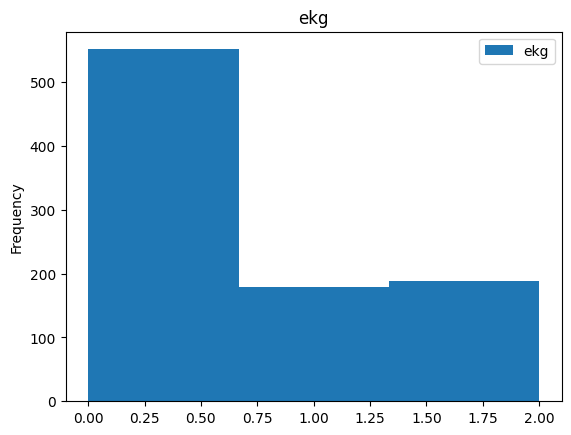

In [8]:
### построение гистограммы 
df_1.plot(y='ekg', title='ekg', kind='hist', bins=3);

In [9]:
### посмотрим уникальные значения столбца
df_1.slope.unique()

array([ 3.,  2.,  1., nan])

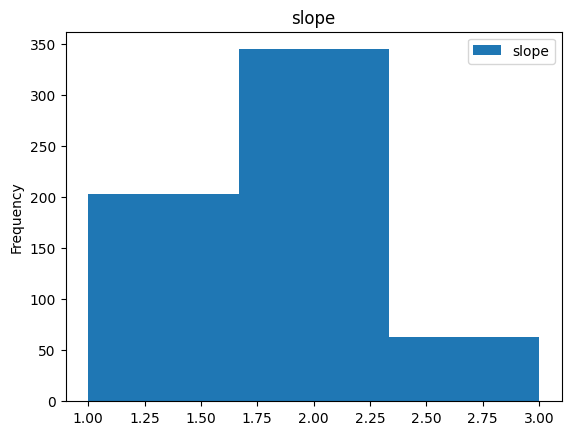

In [10]:
### построение гистограммы 
df_1.plot(y='slope', title='slope', kind='hist', bins=3);

In [11]:
### посмотрим уникальные значения столбца
df_1.fluro_ca.unique()

array([ 0.,  3.,  2.,  1., nan])

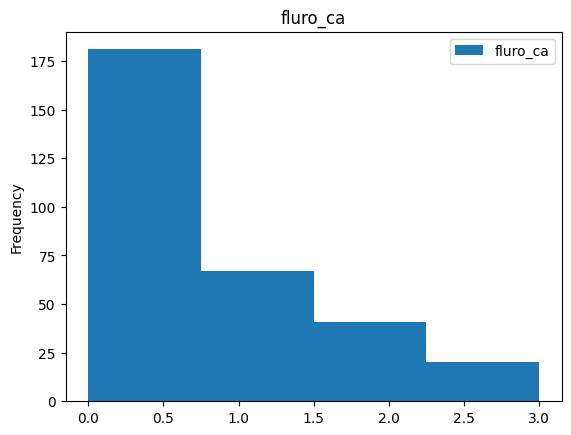

In [12]:
### построение гистограммы 
df_1.plot(y='fluro_ca', title='fluro_ca', kind='hist', bins=4);

In [13]:
### посмотрим уникальные значения столбца
df_1.thal.unique()

array([ 6.,  3.,  7., nan])

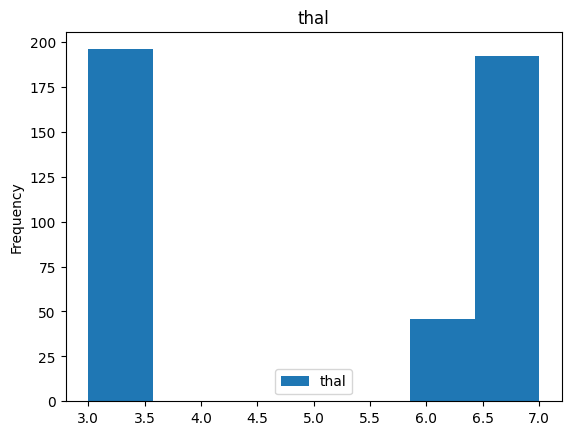

In [14]:
### построение гистограммы 
df_1.plot(y='thal', title='thal', kind='hist', bins=7);

In [15]:
### заполнение пропусков и приведение к типу int для столбца ekg
ekg_median = round(df_1['ekg'].median(), 0)
df_1['ekg'] = df_1['ekg'].fillna(ekg_median)
df_1['ekg'] = df_1['ekg'].astype('int')
display(ekg_median, 'ekg_median')
### заполнение пропусков и приведение к типу int для столбца slope
slope_median = round(df_1['slope'].median(), 0)
df_1['slope'] = df_1['slope'].fillna(slope_median)
df_1['slope'] = df_1['slope'].astype('int')
display(slope_median, 'slope_median')
### заполнение пропусков и приведение к типу int для столбца fluro_ca
fluro_ca_median = round(df_1['fluro_ca'].median(), 0)
df_1['fluro_ca'] = df_1['fluro_ca'].fillna(fluro_ca_median)
df_1['fluro_ca'] = df_1['fluro_ca'].astype('int')
display(fluro_ca_median, 'fluro_ca_median')
### заполнение пропусков и приведение к типу int для столбца thal
thal_median = round(df_1['thal'].median(), 0)
df_1['thal'] = df_1['thal'].fillna(thal_median)
df_1['thal'] = df_1['thal'].astype('int')
display(thal_median, 'thal_median')

0.0

'ekg_median'

2.0

'slope_median'

0.0

'fluro_ca_median'

6.0

'thal_median'

In [16]:
### найдем и удалим дубликаты
display(df_1.duplicated().sum())
df_1 = df_1.drop_duplicates()
display(df_1.info())

2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       918 non-null    int64  
 1   sex       918 non-null    int64  
 2   cp        918 non-null    int64  
 3   trestbps  918 non-null    int32  
 4   chol      918 non-null    int32  
 5   fbs       918 non-null    int64  
 6   ekg       918 non-null    int32  
 7   thalch    918 non-null    int32  
 8   exang     918 non-null    int64  
 9   oldpeak   918 non-null    float64
 10  slope     918 non-null    int32  
 11  fluro_ca  918 non-null    int32  
 12  thal      918 non-null    int32  
 13  target    918 non-null    int64  
dtypes: float64(1), int32(7), int64(6)
memory usage: 82.5 KB


None

#### Матрица диаграмм рассеяния

,age,chol,cp,ekg,exang,fbs,fluro_ca,oldpeak,sex,slope,target,thal,thalch,trestbps
age,1.000000,-0.086015,0.165896,0.213152,0.160074,0.220011,0.219497,0.233772,0.055750,0.077114,0.282039,0.053222,-0.349200,0.230012
chol,-0.086015,1.000000,-0.131743,0.112814,-0.034033,0.089514,0.152694,0.047830,-0.194113,-0.033350,-0.229155,-0.117912,0.226174,0.089693
cp,0.165896,-0.131743,1.000000,0.031383,0.402078,0.020553,0.078904,0.234345,0.168254,0.111634,0.471354,0.183550,-0.338501,0.022985
ekg,0.213152,0.112814,0.031383,1.000000,0.020293,0.142722,0.257638,0.111424,-0.018343,-0.043254,0.061011,-0.114449,0.053953,0.094102
exang,0.160074,-0.034033,0.402078,0.020293,1.000000,-0.003226,0.037750,0.396917,0.153395,0.193799,0.432424,0.205851,-0.353031,0.151841
fbs,0.220011,0.089514,0.020553,0.142722,-0.003226,1.000000,0.060950,0.033404,0.074899,0.071121,0.108114,0.057986,-0.026450,0.143824
fluro_ca,0.219497,0.152694,0.078904,0.257638,0.037750,0.060950,1.000000,0.217962,-0.038494,-0.104389,0.164878,-0.033327,0.038283,0.039063
oldpeak,0.233772,0.047830,0.234345,0.111424,0.396917,0.033404,0.217962,1.000000,0.089808,0.256948,0.366618,0.152947,-0.149529,0.161350
sex,0.055750,-0.194113,0.168254,-0.018343,0.153395,0.074899,-0.038494,0.089808,1.000000,0.106503,0.305445,0.294737,-0.172792,-0.005220
slope,0.077114,-0.033350,0.111634,-0.043254,0.193799,0.071121,-0.104389,0.256948,0.106503,1.000000,0.205742,0.292961,-0.289533,0.050586


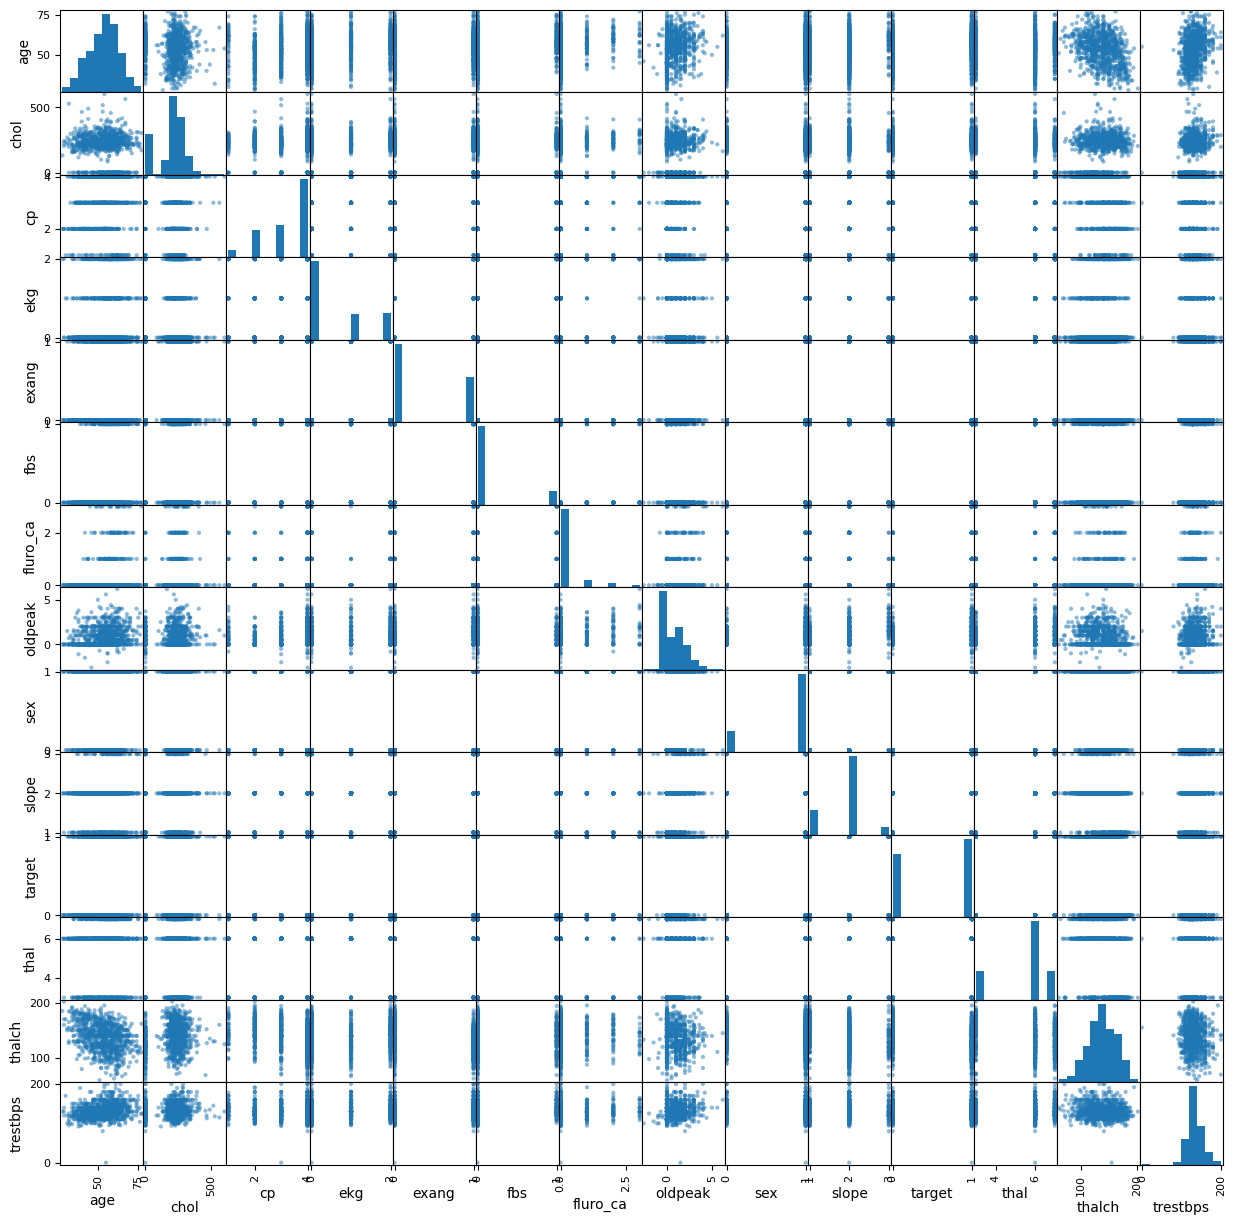

In [17]:
### матрица корреляции
table_corr1 = df_1.pivot_table(index=[df_1.index.values], values=list(df_1.columns))
pd.plotting.scatter_matrix(table_corr1, figsize=(15, 15))
display(table_corr1.corr())

### Открытие и предобработка второй таблицы

In [18]:
### открытие файла со второй таблицей
df_2 = pd.read_csv('Heart_Disease_Prediction.csv')
df_2.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


#### Предобработка данных второй таблицы

In [19]:
### приведем Heart Disease к численным категориям
def hd(row):
    hd = row['Heart Disease']
    if hd == 'Absence':     
        return 0
    if hd == 'Presence':
        return 1
df_2['Heart Disease'] = df_2.apply(hd, axis=1)
### выведем первые 5 строк
df_2.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [20]:
### переименуем столбцы
df_2.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'ekg', 'thalch', 'exang', 'oldpeak', 'slope', 'fluro_ca', 'thal', 'target']
df_2.head()

,age,sex,cp,trestbps,chol,fbs,ekg,thalch,exang,oldpeak,slope,fluro_ca,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [21]:
### проверим на дубликаты
display(df_2.duplicated().sum())
display(df_2.info())

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    int64  
 1   sex       270 non-null    int64  
 2   cp        270 non-null    int64  
 3   trestbps  270 non-null    int64  
 4   chol      270 non-null    int64  
 5   fbs       270 non-null    int64  
 6   ekg       270 non-null    int64  
 7   thalch    270 non-null    int64  
 8   exang     270 non-null    int64  
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    int64  
 11  fluro_ca  270 non-null    int64  
 12  thal      270 non-null    int64  
 13  target    270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


None

#### Матрица диаграмм рассеяния

,age,chol,cp,ekg,exang,fbs,fluro_ca,oldpeak,sex,slope,target,thal,thalch,trestbps
age,1.000000,0.220056,0.096920,0.128171,0.098297,0.123458,0.356081,0.194234,-0.094401,0.159774,0.212322,0.106100,-0.402215,0.273053
chol,0.220056,1.000000,0.090465,0.167652,0.078243,0.025186,0.126541,0.027709,-0.201647,-0.005755,0.118021,0.028836,-0.018739,0.173019
cp,0.096920,0.090465,1.000000,0.074325,0.353160,-0.098537,0.225890,0.167244,0.034636,0.136900,0.417436,0.262659,-0.317682,-0.043196
ekg,0.128171,0.167652,0.074325,1.000000,0.095098,0.053499,0.114368,0.120034,0.039253,0.160614,0.182091,0.007337,-0.074628,0.116157
exang,0.098297,0.078243,0.353160,0.095098,1.000000,-0.004107,0.153347,0.274672,0.180022,0.255908,0.419303,0.321449,-0.380719,0.082793
fbs,0.123458,0.025186,-0.098537,0.053499,-0.004107,1.000000,0.123774,-0.025538,0.042140,0.044076,-0.016319,0.049237,0.022494,0.155681
fluro_ca,0.356081,0.126541,0.225890,0.114368,0.153347,0.123774,1.000000,0.255005,0.086830,0.109498,0.455336,0.255648,-0.265333,0.085697
oldpeak,0.194234,0.027709,0.167244,0.120034,0.274672,-0.025538,0.255005,1.000000,0.097412,0.609712,0.417967,0.324333,-0.349045,0.222800
sex,-0.094401,-0.201647,0.034636,0.039253,0.180022,0.042140,0.086830,0.097412,1.000000,0.050545,0.297721,0.391046,-0.076101,-0.062693
slope,0.159774,-0.005755,0.136900,0.160614,0.255908,0.044076,0.109498,0.609712,0.050545,1.000000,0.337616,0.283678,-0.386847,0.142472


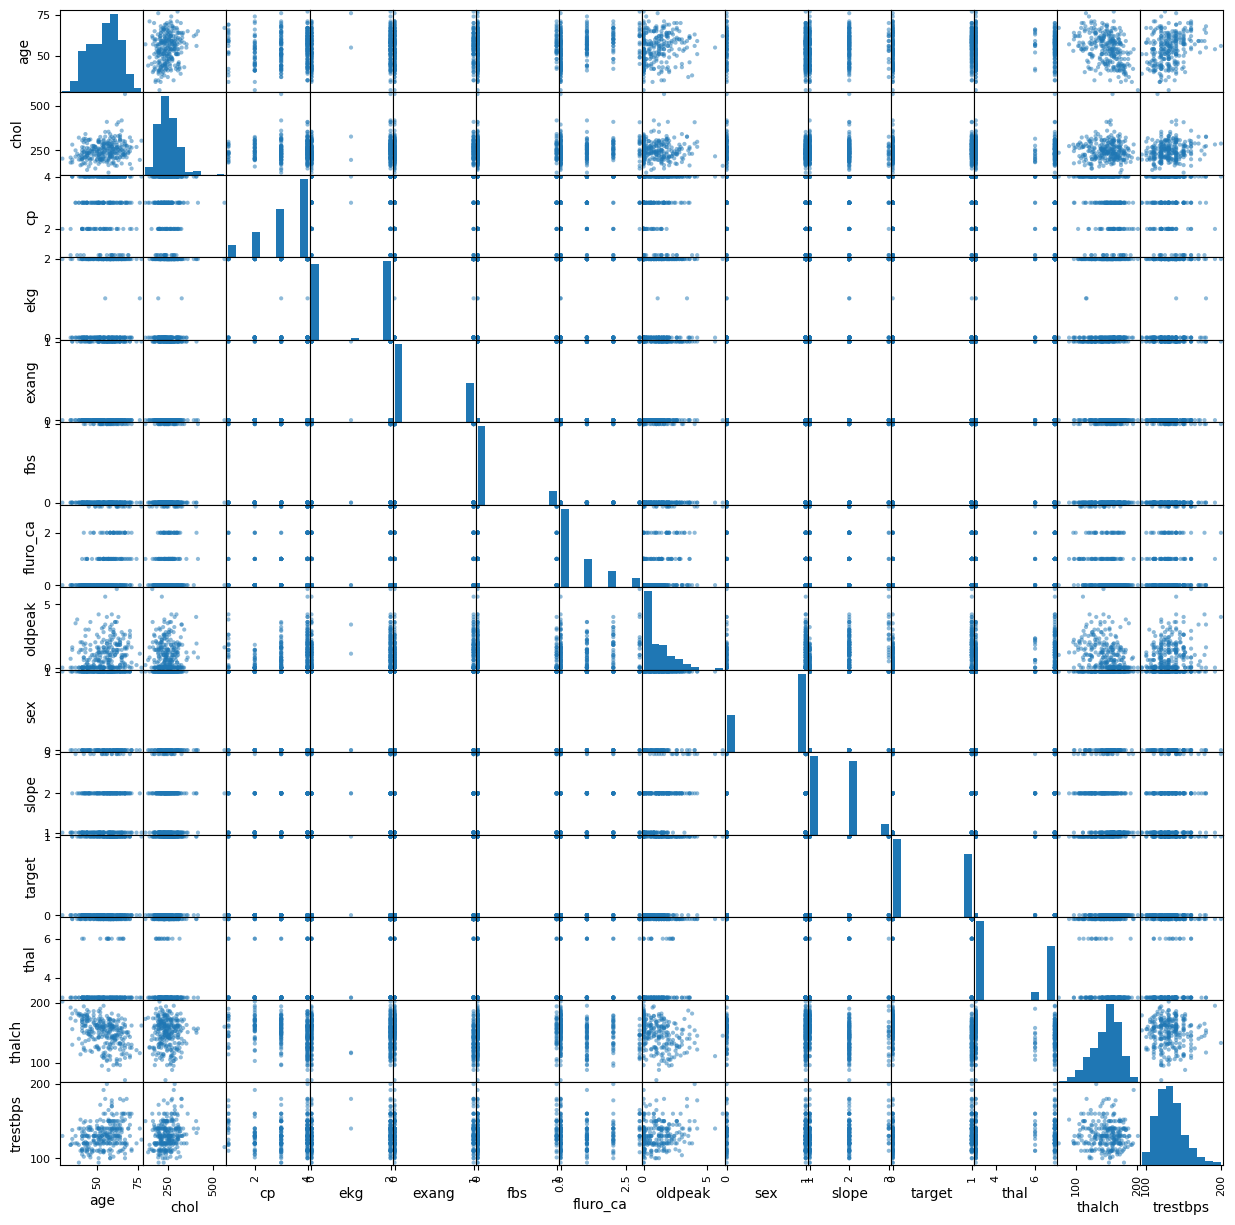

In [22]:
### матрица корреляции
table_corr2 = df_2.pivot_table(index=[df_2.index.values], values=list(df_2.columns))
pd.plotting.scatter_matrix(table_corr2, figsize=(15, 15))
display(table_corr2.corr())

### Объединим таблицы в одну

In [23]:
### объединим таблицы и выведем на экран
data = pd.concat([df_1, df_2], ignore_index=True)
data

,age,sex,cp,trestbps,chol,fbs,ekg,thalch,exang,oldpeak,slope,fluro_ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
1184,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
1185,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
1186,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [24]:
### проверим на выбросы столбец trestbps
display(pd.Series(data.trestbps.unique()).sort_values())
### удалим нулевые значения
data = data.drop(index=58)
### проверим на выбросы столбец chol
display(pd.Series(data.chol.unique()).sort_values())
### удалим нулевые значения
data = data.drop(index=201)
data.info()

58      0
55     80
53     92
29     94
54     95
     ... 
20    180
56    185
51    190
39    192
28    200
Length: 61, dtype: int64

201      0
179     85
172    100
184    117
122    126
      ... 
198    491
193    518
187    529
103    564
191    603
Length: 217, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 0 to 1187
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1186 non-null   int64  
 1   sex       1186 non-null   int64  
 2   cp        1186 non-null   int64  
 3   trestbps  1186 non-null   int64  
 4   chol      1186 non-null   int64  
 5   fbs       1186 non-null   int64  
 6   ekg       1186 non-null   int64  
 7   thalch    1186 non-null   int64  
 8   exang     1186 non-null   int64  
 9   oldpeak   1186 non-null   float64
 10  slope     1186 non-null   int64  
 11  fluro_ca  1186 non-null   int64  
 12  thal      1186 non-null   int64  
 13  target    1186 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 139.0 KB


In [25]:
### найдем и удалим дубликаты
# display(data.duplicated().sum())
# data = data.drop_duplicates()

### Обучение моделей и деление на выборки

In [26]:
### обозначим признаки и цели
features = data.drop(['target'], axis=1)
target = data['target']
### разделим выборки на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(830, 13)

(356, 13)

(830,)

(356,)

In [27]:
### создадим список названий столбцов
column_list = list(features.columns)
### стандартизируем данные и настроим на признаках
scaler = StandardScaler()
scaler.fit(features) 
### преобразуем выборки
features_train = scaler.transform(features_train) 
features_test = scaler.transform(features_test) 
### уберем предупреждение `SettingWithCopy`
pd.options.mode.chained_assignment = None
### получим заголовки для признаков и скорректируем преобразованные выборки
features_train = pd.DataFrame(features_train, columns = column_list, index=target_train.index)
features_test = pd.DataFrame(features_test, columns = column_list, index=target_test.index)

In [28]:
### посмотрим данные после преобразования
display(features_train.head(2))
display(features_test.head(2))

,age,sex,cp,trestbps,chol,fbs,ekg,thalch,exang,oldpeak,slope,fluro_ca,thal
473,0.351192,-1.803024,-2.387137,-0.099442,0.958236,-0.420223,-0.802353,-1.681088,-0.745943,0.09200,0.386492,-0.445311,0.396973
1147,-0.182800,0.554624,-2.387137,-0.756479,-0.247366,-0.420223,1.496175,1.967165,-0.745943,-0.83268,0.386492,-0.445311,0.396973


,age,sex,cp,trestbps,chol,fbs,ekg,thalch,exang,oldpeak,slope,fluro_ca,thal
637,-0.076002,0.554624,-1.318377,-0.099442,-2.085416,-0.420223,0.346911,-0.808680,-0.745943,-0.185404,2.205459,-0.445311,0.396973
585,-0.716792,0.554624,0.819142,1.543151,0.790242,-0.420223,0.346911,0.698207,1.340586,1.941361,0.386492,-0.445311,0.396973


#### Случайный лес

In [29]:
%%time
### обучим модель случайного леса с помощью gridsearch для расчета f1 меры
### параметры по сетке
parameters = {
    'n_estimators': [20, 40, 80, 160],
    'max_depth': [13, 21, 34, 55],
    'min_samples_leaf': [4, 5, 6, 7]
}
ran_for = RandomForestClassifier(class_weight='balanced', random_state=42)
clf = GridSearchCV(ran_for, parameters, scoring='f1', cv=15, n_jobs=-1)
clf.fit(features_train, target_train)
score_1 = round(clf.best_score_, 4)
display(clf.best_score_)
display(clf.best_params_)

0.8621870400738629

{'max_depth': 21, 'min_samples_leaf': 5, 'n_estimators': 20}

CPU times: total: 2.67 s
Wall time: 31.5 s


In [30]:
%%time
### обучим модель случайного леса с помощью gridsearch для расчета roc-auc
clf_roc_auc = GridSearchCV(ran_for, parameters, scoring='roc_auc', cv=15, n_jobs=-1)
clf_roc_auc.fit(features_train, target_train)
score_2 = round(clf_roc_auc.best_score_, 4)
display(clf_roc_auc.best_score_)
display(clf_roc_auc.best_params_)

0.9235933457772538

{'max_depth': 13, 'min_samples_leaf': 4, 'n_estimators': 160}

CPU times: total: 1.91 s
Wall time: 27.1 s


#### Решающее дерево

In [31]:
%%time
### обучим модель решающего дерева с помощью gridsearch для расчета f1 меры
### параметры по сетке
parameters_two = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [7, 8, 9, 10],
    'max_features': [3, 4, 5, 6]
}
dec_thr = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf_two = GridSearchCV(dec_thr, parameters_two, scoring='f1', cv=15, n_jobs=-1)
clf_two.fit(features_train, target_train)
score_3 = round(clf_two.best_score_, 4)
display(clf_two.best_score_)
display(clf_two.best_params_)

0.8336160753168212

{'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 7}

CPU times: total: 797 ms
Wall time: 1.57 s


In [32]:
%%time
### обучим модель решающего дерева с помощью gridsearch для расчета roc-auc
clf_two_roc_auc = GridSearchCV(dec_thr, parameters_two, scoring='roc_auc', cv=15, n_jobs=-1)
clf_two_roc_auc.fit(features_train, target_train)
score_4 = round(clf_two_roc_auc.best_score_, 4)
display(clf_two_roc_auc.best_score_)
display(clf_two_roc_auc.best_params_)

0.8814194256148279

{'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 7}

CPU times: total: 922 ms
Wall time: 1.62 s


#### Логистическая регрессия

In [33]:
%%time
### обучим модель логистической регрессии с помощью gridsearch для расчета f1 меры
### параметры по сетке
parameters_thr = {
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'penalty': ['l2'],
    'max_iter': [10000, 15000]
}
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
clf_thr = GridSearchCV(log_reg, parameters_thr, scoring='f1', cv=15, n_jobs=-1)
clf_thr.fit(features_train, target_train)
score_5 = round(clf_thr.best_score_, 4)
display(clf_thr.best_score_)
display(clf_thr.best_params_)

0.8336136293203912

{'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

CPU times: total: 141 ms
Wall time: 279 ms


In [34]:
%%time
### обучим модель логистической регрессии с помощью gridsearch для расчета roc-auc
clf_thr_roc_auc = GridSearchCV(log_reg, parameters_thr, scoring='roc_auc', cv=15, n_jobs=-1)
clf_thr_roc_auc.fit(features_train, target_train)
score_6 = round(clf_thr_roc_auc.best_score_, 4)
display(clf_thr_roc_auc.best_score_)
display(clf_thr_roc_auc.best_params_)

0.896818940956872

{'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

CPU times: total: 156 ms
Wall time: 272 ms


#### SVC

In [35]:
%%time
### обучим модель SVC с помощью gridsearch для расчета f1 меры
### параметры по сетке
parameters_four = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 4.0, 10.0]
}
s_v_c = SVC(class_weight='balanced', random_state=42)
clf_four = GridSearchCV(s_v_c, parameters_four, scoring='f1', cv=15, n_jobs=-1)
clf_four.fit(features_train, target_train)
score_7 = round(clf_four.best_score_, 4)
display(clf_four.best_score_)
display(clf_four.best_params_)

0.8452221117767671

{'C': 2.0, 'gamma': 'scale', 'kernel': 'rbf'}

CPU times: total: 500 ms
Wall time: 4.21 s


In [36]:
%%time
### обучим модель SVC с помощью gridsearch для расчета roc-auc
clf_four_roc_auc = GridSearchCV(s_v_c, parameters_four, scoring='roc_auc', cv=15, n_jobs=-1)
clf_four_roc_auc.fit(features_train, target_train)
score_8 = round(clf_four_roc_auc.best_score_, 4)
display(clf_four_roc_auc.best_score_)
display(clf_four_roc_auc.best_params_)

0.909698398663916

{'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}

CPU times: total: 703 ms
Wall time: 4.9 s


#### CatBoostClassifier

In [37]:
%%time
### обучим модель catboost с помощью gridsearch для расчета f1 меры
### параметры по сетке
parameters_cbc = {
    'depth' : [10, 15],
    'learning_rate' : [0.05, 0.1],
    'iterations' : [10, 20],
    'loss_function': ['Logloss', 'CrossEntropy']
}
cbc_clf = CatBoostClassifier(random_state=42)
clf_catboost = GridSearchCV(cbc_clf, parameters_cbc, scoring='f1', cv=15, n_jobs=-1)
clf_catboost.fit(features_train, target_train)
score_9 = round(clf_catboost.best_score_, 4)
display(clf_catboost.best_score_)
display(clf_catboost.best_params_)

0:	learn: 0.6791639	total: 533ms	remaining: 10.1s
1:	learn: 0.6645127	total: 933ms	remaining: 8.39s
2:	learn: 0.6365540	total: 934ms	remaining: 5.29s
3:	learn: 0.6176201	total: 994ms	remaining: 3.98s
4:	learn: 0.5934893	total: 996ms	remaining: 2.99s
5:	learn: 0.5801208	total: 1.4s	remaining: 3.26s
6:	learn: 0.5655037	total: 1.58s	remaining: 2.94s
7:	learn: 0.5470791	total: 1.63s	remaining: 2.45s
8:	learn: 0.5304120	total: 1.63s	remaining: 2s
9:	learn: 0.5215463	total: 2s	remaining: 2s
10:	learn: 0.5126607	total: 2.38s	remaining: 1.95s
11:	learn: 0.5046622	total: 2.76s	remaining: 1.84s
12:	learn: 0.4948605	total: 2.85s	remaining: 1.53s
13:	learn: 0.4861691	total: 3.22s	remaining: 1.38s
14:	learn: 0.4777970	total: 3.59s	remaining: 1.2s
15:	learn: 0.4677723	total: 3.68s	remaining: 919ms
16:	learn: 0.4586589	total: 3.7s	remaining: 653ms
17:	learn: 0.4489621	total: 3.7s	remaining: 411ms
18:	learn: 0.4421237	total: 4.07s	remaining: 214ms
19:	learn: 0.4354424	total: 4.43s	remaining: 0us


0.8473878428690422

{'depth': 15,
 'iterations': 20,
 'learning_rate': 0.1,
 'loss_function': 'Logloss'}

CPU times: total: 12.4 s
Wall time: 3min 33s


In [38]:
%%time
### обучим модель catboost с помощью gridsearch для расчета roc-auc
clf_cbc_roc_auc = GridSearchCV(cbc_clf, parameters_cbc, scoring='roc_auc', cv=15, n_jobs=-1)
clf_cbc_roc_auc.fit(features_train, target_train)
score_10 = round(clf_cbc_roc_auc.best_score_, 4)
display(clf_cbc_roc_auc.best_score_)
display(clf_cbc_roc_auc.best_params_)

0:	learn: 0.6791639	total: 396ms	remaining: 7.52s
1:	learn: 0.6645127	total: 826ms	remaining: 7.43s
2:	learn: 0.6365540	total: 827ms	remaining: 4.68s
3:	learn: 0.6176201	total: 874ms	remaining: 3.49s
4:	learn: 0.5934893	total: 875ms	remaining: 2.62s
5:	learn: 0.5801208	total: 1.24s	remaining: 2.89s
6:	learn: 0.5655037	total: 1.42s	remaining: 2.64s
7:	learn: 0.5470791	total: 1.47s	remaining: 2.2s
8:	learn: 0.5304120	total: 1.47s	remaining: 1.8s
9:	learn: 0.5215463	total: 1.83s	remaining: 1.83s
10:	learn: 0.5126607	total: 2.22s	remaining: 1.81s
11:	learn: 0.5046622	total: 2.59s	remaining: 1.73s
12:	learn: 0.4948605	total: 2.68s	remaining: 1.44s
13:	learn: 0.4861691	total: 3.03s	remaining: 1.3s
14:	learn: 0.4777970	total: 3.39s	remaining: 1.13s
15:	learn: 0.4677723	total: 3.48s	remaining: 870ms
16:	learn: 0.4586589	total: 3.5s	remaining: 618ms
17:	learn: 0.4489621	total: 3.51s	remaining: 390ms
18:	learn: 0.4421237	total: 3.88s	remaining: 204ms
19:	learn: 0.4354424	total: 4.25s	remaining: 

0.909255984543341

{'depth': 15,
 'iterations': 20,
 'learning_rate': 0.1,
 'loss_function': 'Logloss'}

CPU times: total: 12.4 s
Wall time: 3min 33s


### Выбор модели

In [39]:
### выведем результаты как таблицу с данными
total_row_1 = ['f1', score_1, score_3, score_5, score_7, score_9]
total_row_2 = ['roc_auc', score_2, score_4, score_6, score_8, score_10]
data_temp = pd.DataFrame([total_row_1, total_row_2])
data_temp.columns = ['metrics', 'random_forest', 'decision_tree', 'logistic_regression', 'svc', 'cat_boost']
display(data_temp)

,metrics,random_forest,decision_tree,logistic_regression,svc,cat_boost
0,f1,0.8622,0.8336,0.8336,0.8452,0.8474
1,roc_auc,0.9236,0.8814,0.8968,0.9097,0.9093


### Тестирование лучших моделей

In [40]:
### обучим модель на выборке
model_test = RandomForestClassifier(random_state=42, max_depth=21, min_samples_leaf=5, n_estimators=20, class_weight='balanced') 
model_test.fit(features_train, target_train)
### тестирование модели случайного леса
predictions_test = pd.Series(model_test.predict(features_test), index=features_test.index) 
result_test = f1_score(target_test, predictions_test)
### выведем результат на экран
display(f'Результат модели случайного леса на тестовой выборке: {result_test}')

'Результат модели случайного леса на тестовой выборке: 0.8426666666666667'

In [41]:
### обучим модель на выборке
model_test2 = CatBoostClassifier(random_state=42, depth=15, iterations=20, learning_rate=0.1, loss_function='Logloss') 
model_test2.fit(features_train, target_train)
### тестирование модели catboost
predictions_test2 = pd.Series(model_test2.predict(features_test), index=features_test.index) 
result_test2 = f1_score(target_test, predictions_test2)
### выведем результат на экран
display(f'Результат модели catboost на тестовой выборке: {result_test2}')

0:	learn: 0.6791639	total: 373ms	remaining: 7.08s
1:	learn: 0.6645127	total: 754ms	remaining: 6.78s
2:	learn: 0.6365540	total: 754ms	remaining: 4.27s
3:	learn: 0.6176201	total: 800ms	remaining: 3.2s
4:	learn: 0.5934893	total: 801ms	remaining: 2.4s
5:	learn: 0.5801208	total: 1.19s	remaining: 2.77s
6:	learn: 0.5655037	total: 1.37s	remaining: 2.55s
7:	learn: 0.5470791	total: 1.42s	remaining: 2.13s
8:	learn: 0.5304120	total: 1.42s	remaining: 1.74s
9:	learn: 0.5215463	total: 1.8s	remaining: 1.8s
10:	learn: 0.5126607	total: 2.21s	remaining: 1.8s
11:	learn: 0.5046622	total: 2.62s	remaining: 1.75s
12:	learn: 0.4948605	total: 2.72s	remaining: 1.46s
13:	learn: 0.4861691	total: 3.12s	remaining: 1.34s
14:	learn: 0.4777970	total: 3.52s	remaining: 1.18s
15:	learn: 0.4677723	total: 3.62s	remaining: 904ms
16:	learn: 0.4586589	total: 3.64s	remaining: 642ms
17:	learn: 0.4489621	total: 3.64s	remaining: 405ms
18:	learn: 0.4421237	total: 4.03s	remaining: 212ms
19:	learn: 0.4354424	total: 4.4s	remaining: 0u

'Результат модели catboost на тестовой выборке: 0.8241758241758242'

'ROC-AUC для модели случайного леса:'

0.9119221873712892

'ROC-AUC для модели CatBoost:'

0.9139498780217343

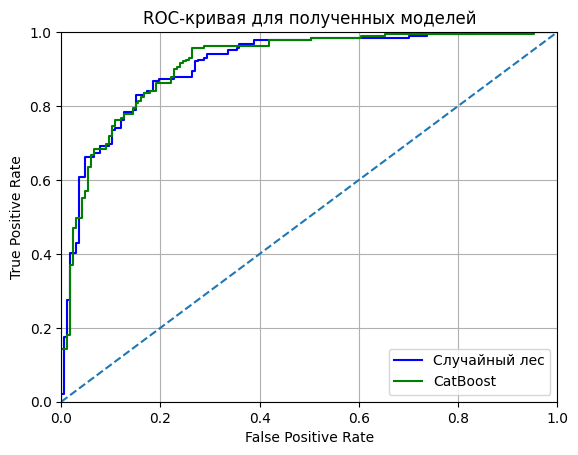

In [42]:
### рассчитаем вероятности
probabilities_test = model_test.predict_proba(features_test)
probabilities_test_a = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test_a)
probabilities_test2 = model_test2.predict_proba(features_test)
probabilities_test_a2 = probabilities_test2[:, 1]
auc_roc2 = roc_auc_score(target_test, probabilities_test_a2)
### посчитаем площадь под кривой
display('ROC-AUC для модели случайного леса:', auc_roc)
display('ROC-AUC для модели CatBoost:', auc_roc2)
### рассчитаем значения FPR, TPR и порога
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test_a)  
fpr2, tpr2, thresholds2 = roc_curve(target_test, probabilities_test_a2)  
### построим график с сеткой
plt.figure()
plt.grid(True)
plt.plot(fpr, tpr, color='b')
plt.plot(fpr2, tpr2, color='g')
### ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
### установим границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
### подшишем оси
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
### укажем заголовок
plt.title('ROC-кривая для полученных моделей')
plt.legend(['Случайный лес', 'CatBoost'])
plt.show()